In [2]:
import numpy as np
import astropy.units as u
from astropy.io import fits

import time
import os
from pathlib import Path

import poppy

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
platform = jax.devices()[0].platform
device = jax.devices()[0].device_kind

print(f'Jax platform: {platform}')
print(f'Jax device: {device}')

import utils
import imshows
from imshows import *

wavelength = 633*u.nm
pupil_diam = 10*u.mm
fl = 200*u.mm
fnum = fl.to_value(u.mm)/pupil_diam.to_value(u.mm)

bw = 0.1
nwaves = 5
wavelengths = jnp.linspace(wavelength-wavelength*bw/2.0, wavelength+wavelength*bw/2.0, num=nwaves)
spectrum = jnp.linspace(1, 2, num=nwaves)

npix = 200
oversample = 4
N = int(npix*oversample)
nim = 200

pixelscale_lamD = 1/oversample
um_per_lamD = wavelength.to(u.um) * fnum
pixelscale_m = pixelscale_lamD * um_per_lamD.to_value(u.m)
print(pixelscale_lamD, pixelscale_m)

def pad_or_crop( arr_in, npix ):
    n_arr_in = arr_in.shape[0]
    if n_arr_in == npix:
        return arr_in
    elif npix < n_arr_in:
        x1 = n_arr_in // 2 - npix // 2
        x2 = x1 + npix
        arr_out = arr_in[x1:x2,x1:x2]
    else:
        arr_out = jnp.zeros((npix,npix), dtype=arr_in.dtype)
        x1 = npix // 2 - n_arr_in // 2
        x2 = x1 + n_arr_in
        arr_out = arr_out.at[x1:x2,x1:x2].set(arr_in)
    return arr_out

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe
0.25 3.1649999999999998e-06


In [35]:
wf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=npix, oversample=1)
ap = poppy.NgonAperture(nsides=12, radius=pupil_diam/2).get_transmission(wf)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


In [36]:
utils.save_fits(f'aperture_{npix:d}.fits', ap.get())

Saved data to:  aperture_200.fits


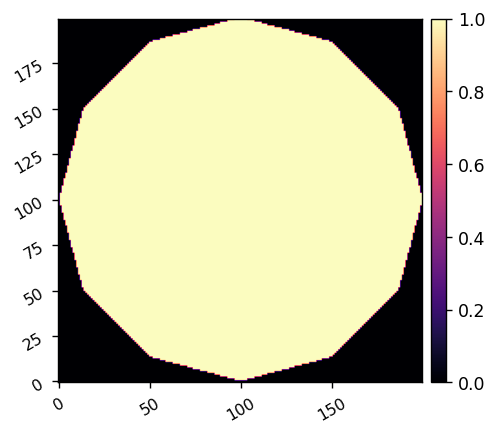

In [32]:
ap = jnp.asarray(fits.getdata(f'aperture_{npix:d}.fits'))
imshow1(ap)

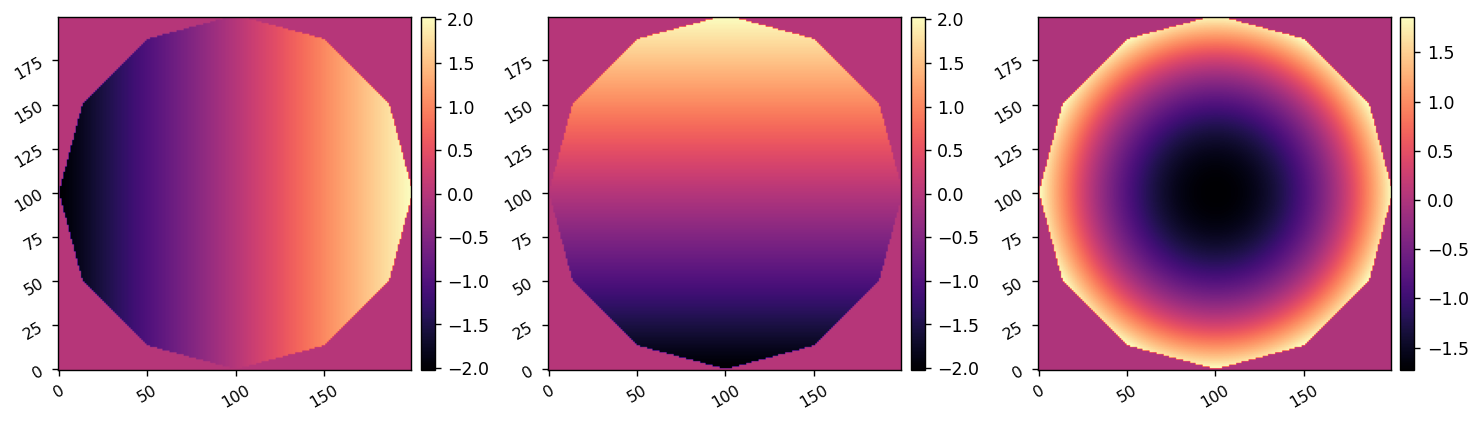

In [33]:
nmodes = 25
zmodes = poppy.zernike.arbitrary_basis(ap, nterms=nmodes+1, outside=0)[1:]
modes = zmodes.reshape(nmodes, npix**2).T
imshow3(zmodes[0], zmodes[1], zmodes[2])

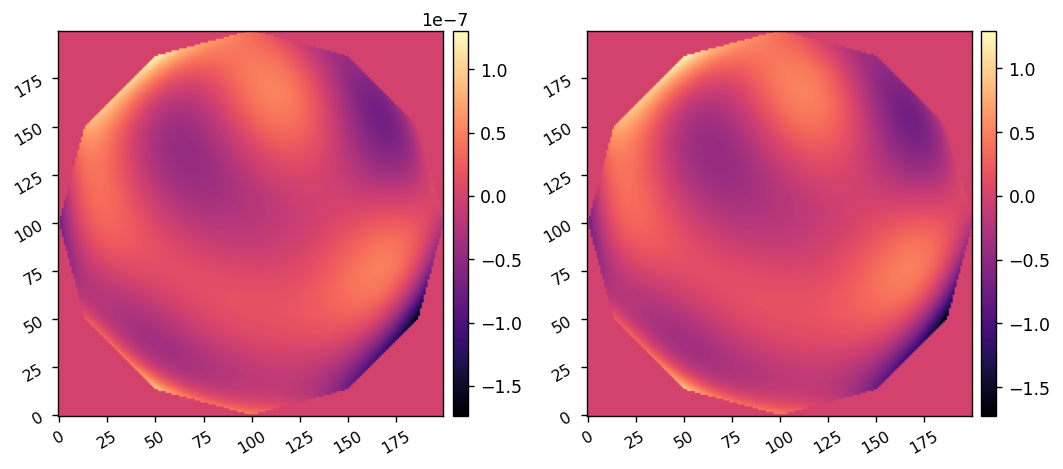

In [34]:
np.random.seed(123)
a = 5e-9 * np.random.randn(nmodes)
a[2] = 0 # just set the defocus coefficient to 0
wfe = modes.get().dot(a).reshape(npix,npix)
pupil = ap*jnp.exp(1j*2*np.pi*wfe/wavelength.to_value(u.m))
imshow2(wfe, np.asarray(jnp.angle(pupil)))

In [1]:
import model

mod = model.ForwardModel(npix, nim, fnum, pixelscale_m, 
                           wavelength.to_value(u.m), wavelengths, 
                           long_defocus, 
                           spectrum=spectrum)

# Do the estimation

In [12]:
import estimation

In [13]:
wavelengths = jnp.array([wavelength.to_value(u.m)])
spectrum = jnp.linspace(1, 2, num=1)

In [15]:
mod = model.ForwardModel(npix, nim, fnum, pixelscale_m, 
                           wavelength.to_value(u.m), wavelengths, 
                           long_defocus, 
                           spectrum=spectrum)

In [24]:
estimator = estimation.Estimation(mod, estimate_phase=True, maxiter=1000, wreg=1e-2)

In [25]:
fit, err, objvals = estimator.run(images, ap)

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 2.3862837916228356e-25 Stepsize:1.0  Decrease Error:0.0  Curvature Error:2.3862837916228356e-25 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 3.723991934752722e-25 Stepsize:1.0  Decrease Error:0.0  Curvature Error:3.723991934752722e-25 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 1.763621469587453e-20 Stepsize:1.0  Decrease Error:0.0  Curvature Error:1.763621469587453e-20 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 6.858306978147816e-14 Stepsize:1.0  Decrease Error:0.0  Curvature Error:6.858306978147816e-14 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 7.909845886572627e-10 Stepsize:1.0  Decrease Error:0.0  Curvature Error:7.909845886572627e-10 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. cri

2024-04-11 14:54:03.533620: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 2.7051273501165775e-05 Stepsize:0.0895712484070453  Decrease Error:0.0  Curvature Error:2.7051273501165775e-05 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.1791424968140906  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.2687137452211359  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 1.3073805354898277e-05 Stepsize:0.40307061783170384  Decrease Error:0.0  Curvature Error:1.3073805354898277e-05 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.8061412356634077  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decreas

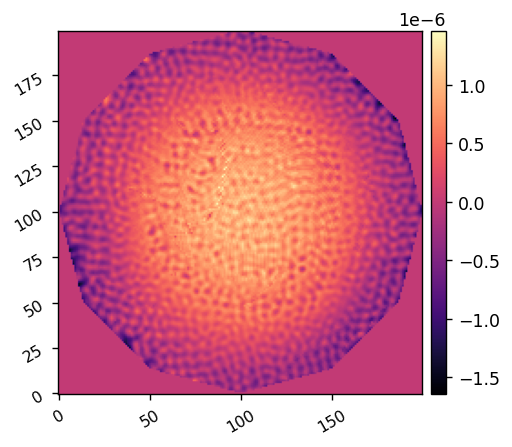

In [28]:
opd_est = fit[-1].reshape((npix,npix)) * ap * 1e-6

imshow1(opd_est, )

Text(0, 0.5, 'objective function value')

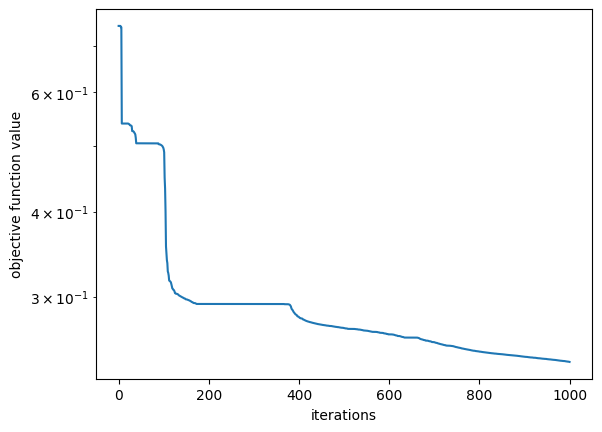

In [27]:
plt.semilogy(objvals)
plt.xlabel('iterations')
plt.ylabel('objective function value')